In [116]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data_vulnerabilities = pd.read_json(
    "dataset/vulnerabilities.json")


In [3]:
data_vulnerabilities.head()

,name,path,source,vulnerabilities
0,FibonacciBalance.sol,dataset/access_control/FibonacciBalance.sol,https://github.com/sigp/solidity-security-blog,"[{'lines': [31], 'category': 'access_control'}..."
1,arbitrary_location_write_simple.sol,dataset/access_control/arbitrary_location_writ...,https://smartcontractsecurity.github.io/SWC-re...,"[{'lines': [27], 'category': 'access_control'}]"
2,incorrect_constructor_name1.sol,dataset/access_control/incorrect_constructor_n...,https://github.com/trailofbits/not-so-smart-co...,"[{'lines': [20], 'category': 'access_control'}]"
3,incorrect_constructor_name2.sol,dataset/access_control/incorrect_constructor_n...,https://smartcontractsecurity.github.io/SWC-re...,"[{'lines': [18], 'category': 'access_control'}]"
4,incorrect_constructor_name3.sol,dataset/access_control/incorrect_constructor_n...,https://smartcontractsecurity.github.io/SWC-re...,"[{'lines': [17], 'category': 'access_control'}]"


In [4]:
data_vulnerabilities.vulnerabilities[0]


[{'lines': [31], 'category': 'access_control'},
 {'lines': [38], 'category': 'access_control'}]

In [5]:
all_categories = []
for idx, row in data_vulnerabilities.iterrows():
    for i in row['vulnerabilities']:
        # print(i)
        all_categories.append(i['category'])
unique_categories = set(all_categories)

In [6]:
unique_categories

{'access_control',
 'arithmetic',
 'bad_randomness',
 'denial_of_service',
 'front_running',
 'other',
 'reentrancy',
 'short_addresses',
 'time_manipulation',
 'unchecked_low_level_calls'}

In [7]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
label_encoded_category = label_encoder.fit_transform(list(unique_categories))

In [8]:
def parse_clean_Data(data, filename):
    indexes_to_drop = []
    for i, d in enumerate(data):
        # Convert bytes to string
        data[i] = data[i].decode("utf-8")
        d = d.decode("utf-8")
        # print(type(d))
        if d.startswith("/*"):
            indexes_to_drop.append(i)
            data[i] = ""
            # pass
        elif d.startswith("*") or d.__contains__("@"):
            indexes_to_drop.append(i)
            data[i] = ""
            # pass
        elif d.startswith(" */"):
            indexes_to_drop.append(i)
            data[i] = ""
            pass
        elif d.startswith("//"):
            indexes_to_drop.append(i)
            data[i] = ""
            pass
        elif d.__contains__("//"):
            data[i] = data[i].split("//")[0]
    # print(indexes_to_drop)
    # result = {f"{filename}":data}
    return data
    # data = data.dropna()
    # data = data.reset_index(drop=True)
    # return data


In [17]:
list_of_dataset=os.listdir("dataset/")
#Loop to check location is directory or not
final_output = {}
for entry in list_of_dataset:
    # Create full path
    fullpath = os.path.join("dataset/", entry)
    # If entry is a directory then get the list of files in this directory 
    if os.path.isdir(fullpath) and entry == "reentrancy":
        print(entry)
        filenames_list = os.listdir(fullpath)
        for filename in filenames_list:
            if(filename!="README.md"):
            # print(filename)
            # Read the file content and print it
                with open(os.path.join(fullpath, filename), 'rb') as f:
                    file_Data = f.read().splitlines()
                    # final_output.append(parse_clean_Data(file_Data, filename))
                    final_output[filename] = parse_clean_Data(file_Data, filename)
                # print()
# print(final_output)
    

reentrancy


In [18]:
all_filenames = []
all_codes = []
all_categories = []
for filename,v in final_output.items():
    temp_V= list(enumerate(v))
    #apply lambda function on list of tuples
    temp_V = list(map(lambda x: (x[0]+1, x[1]), temp_V))
    #get the index for the value in the dataframe
    # print(filename)
    index = data_vulnerabilities[data_vulnerabilities['name'] == filename].index[0]
    for (j,k) in temp_V:    
        for vuln in data_vulnerabilities.vulnerabilities[index]:
            # print(i)
            if j== vuln["lines"][0]:
                all_categories.append(vuln['category'])
                all_codes.append(k)
                all_filenames.append(filename)
            else:
                all_categories.append("No Vulnerability")
                # all_codes.append(temp_V)
                # all_filenames.append(filename)
                all_codes.append(k)
                all_filenames.append(filename)
    # print(index)


In [19]:
final_df = pd.DataFrame(list(zip(all_filenames, all_codes, all_categories)),columns=['filename', 'code', 'category'])

In [141]:
final_df.head()

,filename,code,category
0,0xb93430ce38ac4a6bb47fb1fc085ea669353fd89e.sol,,No Vulnerability
1,0xb93430ce38ac4a6bb47fb1fc085ea669353fd89e.sol,pragma solidity ^0.4.19;,No Vulnerability
2,0xb93430ce38ac4a6bb47fb1fc085ea669353fd89e.sol,contract PrivateBank,No Vulnerability
3,0xb93430ce38ac4a6bb47fb1fc085ea669353fd89e.sol,{,No Vulnerability
4,0xb93430ce38ac4a6bb47fb1fc085ea669353fd89e.sol,mapping (address => uint) public balances;,No Vulnerability


In [20]:
df1=final_df[final_df["category"]=="No Vulnerability"]
df1 = df1.drop_duplicates(subset=['code'], keep='first')
df1

,filename,code,category
0,0xb93430ce38ac4a6bb47fb1fc085ea669353fd89e.sol,,No Vulnerability
6,0xb93430ce38ac4a6bb47fb1fc085ea669353fd89e.sol,pragma solidity ^0.4.19;,No Vulnerability
8,0xb93430ce38ac4a6bb47fb1fc085ea669353fd89e.sol,contract PrivateBank,No Vulnerability
9,0xb93430ce38ac4a6bb47fb1fc085ea669353fd89e.sol,{,No Vulnerability
10,0xb93430ce38ac4a6bb47fb1fc085ea669353fd89e.sol,mapping (address => uint) public balances;,No Vulnerability
...,...,...,...
3432,0xaae1f51cf3339f18b6d3f3bdc75a5facd744b0b8.sol,contract DEP_BANK,No Vulnerability
3527,0x93c32845fae42c83a70e5f06214c8433665c2ab5.sol,contract X_WALLET,No Vulnerability
3574,0x93c32845fae42c83a70e5f06214c8433665c2ab5.sol,function X_WALLET(address log) public{,No Vulnerability
3612,0xf015c35649c82f5467c9c74b7f28ee67665aad68.sol,contract MY_BANK,No Vulnerability


In [21]:
df2 = final_df[final_df["category"]!="No Vulnerability"]
final_df = pd.concat([df1, df2])
print(final_df)

                                            filename  \
0     0xb93430ce38ac4a6bb47fb1fc085ea669353fd89e.sol   
6     0xb93430ce38ac4a6bb47fb1fc085ea669353fd89e.sol   
8     0xb93430ce38ac4a6bb47fb1fc085ea669353fd89e.sol   
9     0xb93430ce38ac4a6bb47fb1fc085ea669353fd89e.sol   
10    0xb93430ce38ac4a6bb47fb1fc085ea669353fd89e.sol   
...                                              ...   
3291  0x23a91059fdc9579a9fbd0edc5f2ea0bfdb70deb4.sol   
3381  0x4e73b32ed6c35f570686b89848e5f39f20ecc106.sol   
3477  0xaae1f51cf3339f18b6d3f3bdc75a5facd744b0b8.sol   
3547  0x93c32845fae42c83a70e5f06214c8433665c2ab5.sol   
3632  0xf015c35649c82f5467c9c74b7f28ee67665aad68.sol   

                                                code          category  
0                                                     No Vulnerability  
6                           pragma solidity ^0.4.19;  No Vulnerability  
8                               contract PrivateBank  No Vulnerability  
9                                  

In [22]:
final_df.reset_index(drop=True, inplace=True)


In [23]:
final_df

,filename,code,category
0,0xb93430ce38ac4a6bb47fb1fc085ea669353fd89e.sol,,No Vulnerability
1,0xb93430ce38ac4a6bb47fb1fc085ea669353fd89e.sol,pragma solidity ^0.4.19;,No Vulnerability
2,0xb93430ce38ac4a6bb47fb1fc085ea669353fd89e.sol,contract PrivateBank,No Vulnerability
3,0xb93430ce38ac4a6bb47fb1fc085ea669353fd89e.sol,{,No Vulnerability
4,0xb93430ce38ac4a6bb47fb1fc085ea669353fd89e.sol,mapping (address => uint) public balances;,No Vulnerability
...,...,...,...
752,0x23a91059fdc9579a9fbd0edc5f2ea0bfdb70deb4.sol,if(msg.sender.call.value(_am)()),reentrancy
753,0x4e73b32ed6c35f570686b89848e5f39f20ecc106.sol,if(msg.sender.call.value(_am)()),reentrancy
754,0xaae1f51cf3339f18b6d3f3bdc75a5facd744b0b8.sol,if(msg.sender.call.value(_am)()),reentrancy
755,0x93c32845fae42c83a70e5f06214c8433665c2ab5.sol,if(msg.sender.call.value(_am)()),reentrancy


In [24]:
final_df["category"].value_counts()

No Vulnerability    731
reentrancy           26
Name: category, dtype: int64

In [25]:
import imblearn
from imblearn.under_sampling import RandomUnderSampler
under_sampleer = RandomUnderSampler(sampling_strategy='majority')
data,y =under_sampleer.fit_resample(final_df,final_df["category"])

In [26]:
data.shape

(52, 3)

In [27]:
type(data)

pandas.core.frame.DataFrame

In [28]:
data["category"].value_counts()

No Vulnerability    26
reentrancy          26
Name: category, dtype: int64

In [52]:
#import TfidfVectorizer from sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
#initialize TfidfVectorizer 
tfidf_vectorizer=TfidfVectorizer(ngram_range=(2,2))
#convert the text into a matrix of TF-IDF features
tfidf_vectorizer_vectors=tfidf_vectorizer.fit_transform(data['code']).todense()

In [143]:
tfidf_vectorizer_vectors[1:5]

matrix([[0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.28867513, 0.        , 0.28867513, 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.28867513,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.28867513, 0.28867513, 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.28867513, 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.28867513, 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.28867513, 0

In [53]:
tfidf_vectorizer_vectors.shape

(52, 110)

In [54]:
from sklearn.preprocessing import LabelEncoder
l_e = LabelEncoder()
data['category'] = l_e.fit_transform(data['category'])

In [55]:
data

,filename,code,category
0,spank_chain_payment.sol,return string(result);,0
1,spank_chain_payment.sol,This is moved to the base contract since ...,0
2,spank_chain_payment.sol,if (Channels[_lcID].partyAddresses[0]...,0
3,0x627fa62ccbb1c1b04ffaecd72a53e37fc0e17839.sol,owner=newOwner;,0
4,spank_chain_payment.sol,channel.updateLCtimeout,0
5,0xb93430ce38ac4a6bb47fb1fc085ea669353fd89e.sol,public,0
6,spank_chain_payment.sol,"function allowance(address _owner, addres...",0
7,0x7b368c4e805c3870b6c49a3f1f49f69af8662cf3.sol,function W_WALLET(address log) public{,0
8,0xb93430ce38ac4a6bb47fb1fc085ea669353fd89e.sol,Message LastMsg;,0
9,spank_chain_payment.sol,if (v < 27 || v > 28) {,0


In [121]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(tfidf_vectorizer_vectors, data['category'], test_size=0.2, random_state=42)


In [77]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
mean_f1_scores_lr = [ ]
sd_f1_scores_lr = []
C_list = [0.01, 0.1, 1, 10]
for c in C_list:
    model = LogisticRegression(C=c)
    scoring = cross_val_score(model,tfidf_vectorizer_vectors, data['category'],cv=5,scoring = 'f1')
    mean_f1_scores_lr.append(np.array(scoring).mean())
    sd_f1_scores_lr.append(np.array(scoring).std())

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https:/

In [78]:
mean_f1_scores_lr

[0.775, 0.8877777777777778, 0.8877777777777778, 0.8877777777777778]

In [80]:
sd_f1_scores_lr

[0.2, 0.10185925898991861, 0.10185925898991861, 0.10185925898991861]

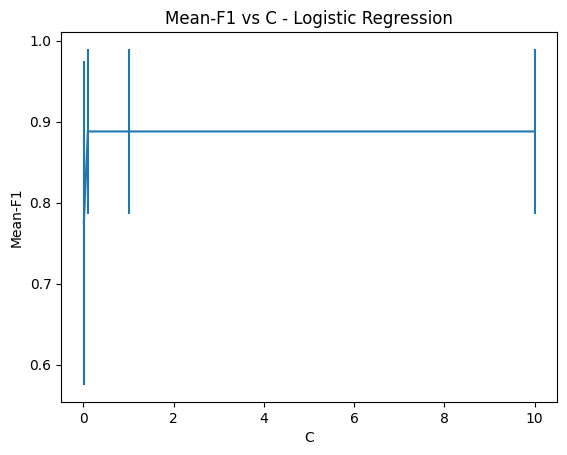

In [82]:
plt.errorbar(C_list,mean_f1_scores_lr,yerr = sd_f1_scores_lr)
plt.xlabel("C")
plt.ylabel("Mean-F1")
plt.title("Mean-F1 vs C - Logistic Regression")
plt.show()

In [109]:
from sklearn.metrics import roc_auc_score,roc_curve
def roc_metrics(model, X_test, y_test,predictions):
    roc_auc = roc_auc_score(y_test, predictions)
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1]) 
    return roc_auc, fpr, tpr, thresholds

In [128]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C=0.1)
lr.fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


LogisticRegression(C=0.1)

In [129]:
from sklearn.metrics import accuracy_score,classification_report
accuracy_score(y_test, lr.predict(X_test))
print(classification_report(y_test, lr.predict(X_test)))
# lr.predict(tfidf_vectorizer_vectors)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         5

    accuracy                           1.00        11
   macro avg       1.00      1.00      1.00        11
weighted avg       1.00      1.00      1.00        11



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


<AxesSubplot: >

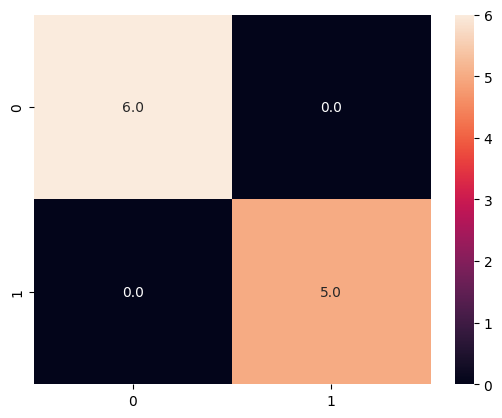

In [130]:
#import confusion_matrix from sklearn
from sklearn.metrics import confusion_matrix
import seaborn as sns
#initialize confusion_matrix
conf_matrix=confusion_matrix(y_test, lr.predict(X_test))
sns.heatmap(conf_matrix, annot=True,fmt=".1f")

In [144]:
lr.coef_

array([[-0.03126561,  0.0290607 , -0.0139824 ,  0.01255029,  0.02186709,
        -0.02765275,  0.00815524,  0.01255029, -0.0139824 , -0.0139824 ,
        -0.01473875, -0.01473875,  0.        , -0.0139824 , -0.0139824 ,
        -0.01473875, -0.04421625, -0.02210812,  0.0266819 , -0.0139824 ,
         0.        , -0.01276413, -0.0139824 , -0.01276413,  0.        ,
        -0.01473875,  0.28797491,  0.        , -0.03954821, -0.06835252,
        -0.04421625, -0.04421625,  0.02282459, -0.0139824 , -0.01276413,
         0.01255029, -0.0139824 , -0.01977411,  0.01255029, -0.0139824 ,
        -0.03417626, -0.01630093,  0.0266819 , -0.0139824 , -0.01473875,
        -0.02210812, -0.01276413, -0.01276413,  0.0266819 , -0.03126561,
         0.0290607 , -0.02468491,  0.28918741, -0.02765275,  0.        ,
        -0.01276413,  0.        ,  0.        , -0.02210812, -0.0139824 ,
        -0.04421625, -0.01276413,  0.29310389, -0.0139824 , -0.0139824 ,
         0.        ,  0.01255029, -0.02468491,  0.0

In [131]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(tfidf_vectorizer_vectors, data['category'])
# dummy_clf.predict(X_test)
print(classification_report(y_test, dummy_clf.predict(X_test)))


              precision    recall  f1-score   support

           0       0.55      1.00      0.71         6
           1       0.00      0.00      0.00         5

    accuracy                           0.55        11
   macro avg       0.27      0.50      0.35        11
weighted avg       0.30      0.55      0.39        11



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

<AxesSubplot: >

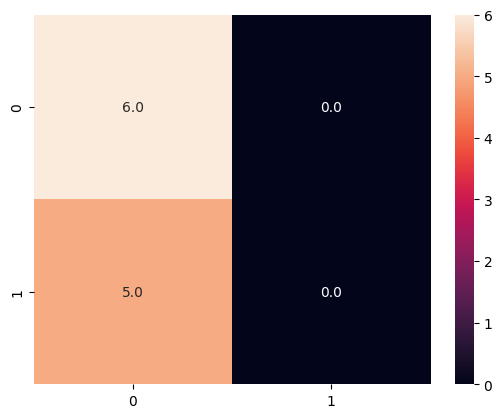

In [132]:
#import confusion_matrix from sklearn
from sklearn.metrics import confusion_matrix
import seaborn as sns
#initialize confusion_matrix
conf_matrix=confusion_matrix(y_test, dummy_clf.predict(X_test))
sns.heatmap(conf_matrix, annot=True,fmt=".1f")

In [96]:
data["category"].value_counts()

0    26
1    26
Name: category, dtype: int64

In [97]:
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
mean_f1_scores_svc = [ ]
sd_f1_scores_svc = []
C_list = [0.01, 0.1, 1, 10]
for c in C_list:
    model = SVC(kernel='linear', C=c)
    scoring = cross_val_score(model,tfidf_vectorizer_vectors, data['category'],cv=5,scoring = 'f1')
    mean_f1_scores_svc.append(np.array(scoring).mean())
    sd_f1_scores_svc.append(np.array(scoring).std())

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https:/

In [98]:
mean_f1_scores_svc

[0.675, 0.8877777777777778, 0.8877777777777778, 0.8877777777777778]

In [99]:
sd_f1_scores_svc

[0.36742346141747667,
 0.10185925898991861,
 0.10185925898991861,
 0.10185925898991861]

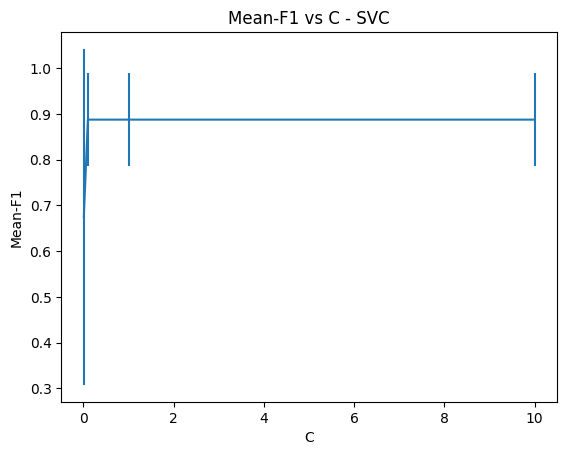

In [100]:
plt.errorbar(C_list,mean_f1_scores_svc,yerr = sd_f1_scores_svc)
plt.xlabel("C")
plt.ylabel("Mean-F1")
plt.title("Mean-F1 vs C - SVC")
plt.show()

In [134]:
#import SVC from sklearn
from sklearn.svm import SVC
#initialize SVC
svc=SVC(C=0.1,probability=True)
#fit the model
svc.fit(X_train,y_train)
print(classification_report(y_test, svc.predict(X_test)))

              precision    recall  f1-score   support

           0       0.86      1.00      0.92         6
           1       1.00      0.80      0.89         5

    accuracy                           0.91        11
   macro avg       0.93      0.90      0.91        11
weighted avg       0.92      0.91      0.91        11



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


<AxesSubplot: >

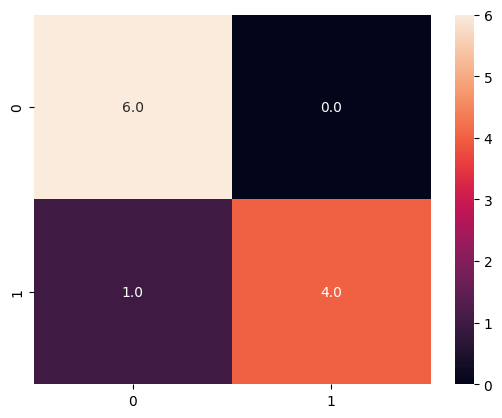

In [135]:
#import confusion_matrix from sklearn
from sklearn.metrics import confusion_matrix
import seaborn as sns
#initialize confusion_matrix
conf_matrix=confusion_matrix(y_test, svc.predict(X_test))
sns.heatmap(conf_matrix, annot=True,fmt=".1f")

In [103]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
mean_f1_scores_k = [ ]
sd_f1_scores_k = []
Ks = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19]
for k in Ks:
    model = KNeighborsClassifier(k)
    scoring = cross_val_score(model,tfidf_vectorizer_vectors, data['category'],cv=5,scoring = 'f1')
    mean_f1_scores_k.append(np.array(scoring).mean())
    sd_f1_scores_k.append(np.array(scoring).std())

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https:/

In [85]:
mean_f1_scores_k

[0.8877777777777778,
 0.8877777777777778,
 0.8918181818181818,
 0.8803030303030303,
 0.9318181818181819,
 0.9318181818181819,
 0.9318181818181819,
 0.9318181818181819,
 0.9318181818181819,
 0.9318181818181819]

In [86]:
sd_f1_scores_k

[0.10185925898991861,
 0.10185925898991861,
 0.1022232203408771,
 0.08386880304907911,
 0.09748913904330557,
 0.09748913904330557,
 0.09748913904330557,
 0.09748913904330557,
 0.09748913904330557,
 0.09748913904330557]

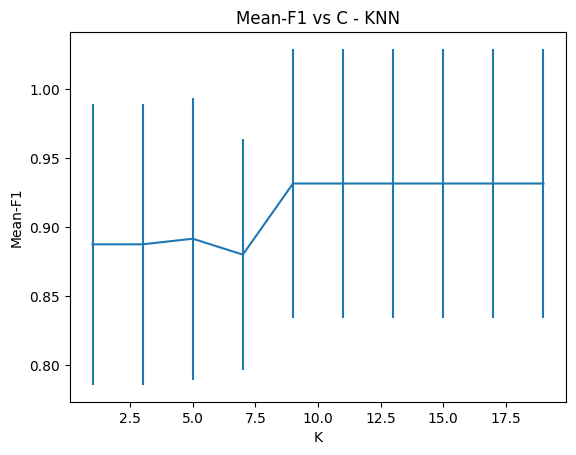

In [136]:
plt.errorbar(Ks,mean_f1_scores_k,yerr = sd_f1_scores_k)
plt.xlabel("K")
plt.ylabel("Mean-F1")
plt.title("Mean-F1 vs C - KNN")
plt.show()

In [137]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train, y_train)
print(classification_report(y_test, knn.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      0.83      0.91         6
           1       0.83      1.00      0.91         5

    accuracy                           0.91        11
   macro avg       0.92      0.92      0.91        11
weighted avg       0.92      0.91      0.91        11



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


<AxesSubplot: >

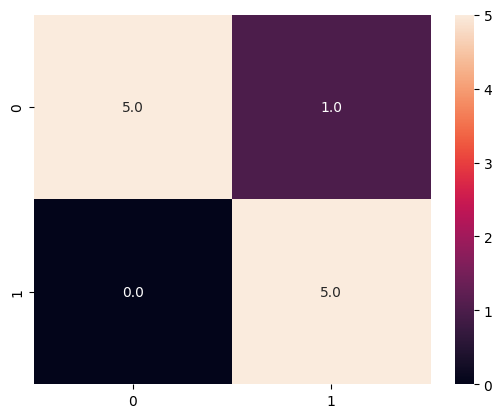

In [138]:
#import confusion_matrix from sklearn
from sklearn.metrics import confusion_matrix
import seaborn as sns
#initialize confusion_matrix
conf_matrix=confusion_matrix(y_test, knn.predict(X_test))
sns.heatmap(conf_matrix, annot=True,fmt=".1f")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https:/

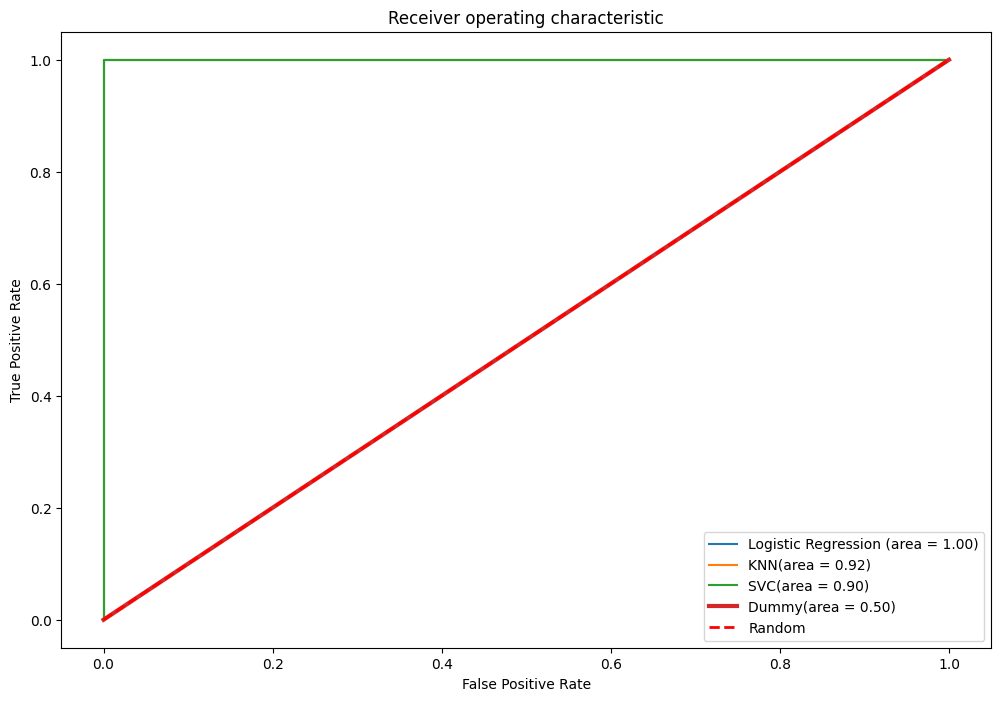

In [139]:
logit_roc_auc_1, fpr_1,tpr_1,_ = roc_metrics(lr, X_test, y_test, lr.predict(X_test))
roc_auc_k_1, fpr_k_1,tpr_k_1,_ = roc_metrics(knn, X_test, y_test, knn.predict(X_test))
roc_auc_svc_1, fpr_svc_1,tpr_svc_1,_ = roc_metrics(svc, X_test, y_test, svc.predict(X_test))
roc_auc_d,fpr_d, tpr_d, thresholds_d = roc_metrics(dummy_clf,X_test,y_test, dummy_clf.predict_proba(X_test)[:,1])
plt.figure(figsize = (12,8)) 
plt.plot(fpr_1, tpr_1, label='Logistic Regression (area = %0.2f)' % logit_roc_auc_1) 
plt.plot(fpr_k_1, tpr_k_1, label='KNN(area = %0.2f)' % roc_auc_k_1) 
plt.plot(fpr_svc_1, tpr_svc_1, label='SVC(area = %0.2f)' % roc_auc_svc_1)
plt.plot(fpr_d,tpr_d, label='Dummy(area = %0.2f)' % roc_auc_d, linewidth='3') 
plt.plot([0, 1], [0, 1],'r--',label='Random', linewidth = '2') 
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate') 
plt.title('Receiver operating characteristic') 
plt.legend(loc="lower right") 
plt.savefig('Log_ROC') 
plt.show()